In [1]:
#!/usr/bin/env python

from __future__ import print_function

try:
    import matplotlib
    matplotlib.use('Agg')
except ImportError:
    pass

import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions
from chainer import Variable
import numpy as np

In [2]:
class CorrNet(chainer.Chain):
    
    def __init__(self, n_units, x_size, y_size, c=0.2):
        super(CorrNet, self).__init__(
            enc = L.Linear(x_size + y_size, n_units),  
            decX = L.Linear(n_units, x_size),
            decY = L.Linear(n_units, y_size),
        )
        self.x_size = x_size
        self.y_size = y_size
        self.c = c

        
    def __call__(self, x, y, test=False):
        x_zeros = xp.zeros(x.shape, dtype=xp.float32)
        y_zeros = xp.zeros(y.shape, dtype=xp.float32)
        
        x1 = F.concat([x, y_zeros])
        h1 = self.enc(x1)
        recX1 = self.decX(h1)
        recY1 = self.decY(h1)
        loss1 = F.mean_squared_error(x, recX1) + F.mean_squared_error(y, recY1)
        
        y2 = F.concat([x_zeros, y])
        h2 = self.enc(y2)
        recX2 = self.decX(h2)
        recY2 = self.decY(h2)
        loss2 = F.mean_squared_error(x, recX2) + F.mean_squared_error(y, recY2)
        
        xy = F.concat([x, y])
        h3 = self.enc(xy)
        recX3 = self.decX(h3)
        recY3 = self.decY(h3)
        loss3 = F.mean_squared_error(x, recX3) + F.mean_squared_error(y, recY3)
            
        batch_size = h1.data.shape[0]
        
        corr = 0
        for one_h1, one_h2 in zip(h1.data, h2.data):
            corr += xp.corrcoef(one_h1, one_h2)[0][1]
        corr /= batch_size
        corr = abs(corr)
        corr = xp.array(corr, dtype=xp.float32)
        corr = Variable(corr, volatile=loss1.volatile)
        
        if test == True:
            return self.recX3, self.recY3
        
        self.loss = loss1 + loss2 + loss3 - self.c * corr
        chainer.reporter.report({'loss': self.loss,
                                'loss1': loss1,
                                'loss2': loss2,
                                'loss3': loss3,
                                'corr': corr,
                                }, self)
        return self.loss
    
    def encX_dec(self, x):
        n_data = x.shape[0]
        y_zeros = xp.zeros([n_data, self.y_size], dtype=xp.float32)
        extended_x = F.concat([x, y_zeros])
        h = self.enc(extended_x)
        return self.decX(h).data, self.decY(h).data


    def encY_dec(self, y):
        n_data = y.shape[0]
        x_zeros = xp.zeros([n_data, self.x_size], dtype=xp.float32)
        extended_x = F.concat([x_zeros, y])
        h = self.enc(extended_x)
        return self.decX(h).data, self.decY(h).data

In [3]:
# def main():
#     parser = argparse.ArgumentParser(description='Chainer example: MNIST')
#     parser.add_argument('--batchsize', '-b', type=int, default=100,
#                         help='Number of images in each mini-batch')
#     parser.add_argument('--epoch', '-e', type=int, default=20,
#                         help='Number of sweeps over the dataset to train')
#     parser.add_argument('--frequency', '-f', type=int, default=-1,
#                         help='Frequency of taking a snapshot')
#     parser.add_argument('--gpu', '-g', type=int, default=-1,
#                         help='GPU ID (negative value indicates CPU)')
#     parser.add_argument('--out', '-o', default='result',
#                         help='Directory to output the result')
#     parser.add_argument('--resume', '-r', default='',
#                         help='Resume the training from snapshot')
#     parser.add_argument('--unit', '-u', type=int, default=1000,
#                         help='Number of units')
#     args = parser.parse_args()
import easydict
args = easydict.EasyDict({
        "batchsize": 100,
        "epoch": 20,
        "gpu": -1,
        "out": "output",
        "resume": False,
        "unit": 20,
        "c": 0.1,
        "frequency": 100,
})


print('GPU: {}'.format(args.gpu))
print('# unit: {}'.format(args.unit))
print('# Minibatch-size: {}'.format(args.batchsize))
print('# epoch: {}'.format(args.epoch))
print('')

from chainer import cuda
xp = cuda.cupy if args.gpu >= 0 else np

GPU: -1
# unit: 20
# Minibatch-size: 100
# epoch: 20



In [4]:
from chainer.datasets import tuple_dataset

def y_label2one_hot(tupled_data):
    x_list, y_list = [], []

    for i in range(len(tupled_data)):
        one_train = list(tupled_data[i])
        label = one_train[1]

        one_hot = np.zeros(10)
        one_hot[label] =1

        x_list.append(one_train[0])
        y_list.append(one_hot.astype(np.float32))
        
    return tuple_dataset.TupleDataset(x_list, y_list)

# Load the MNIST dataset
train, test = chainer.datasets.get_mnist()

train = y_label2one_hot(train)
test = y_label2one_hot(test)

train_iter = chainer.iterators.SerialIterator(train, args.batchsize)
test_iter = chainer.iterators.SerialIterator(test, args.batchsize,
                                             repeat=False, shuffle=False)

x_size = train[0][0].shape[0]
y_size = train[0][1].shape[0]

# Set up a neural network to train
# Classifier reports softmax cross entropy loss and accuracy at every
# iteration, which will be used by the PrintReport extension below.
#     model = L.Classifier(MLP(args.unit, 10))
model = CorrNet(args.unit, x_size, y_size, c=args.c)

if args.gpu >= 0:
    chainer.cuda.get_device(args.gpu).use()  # Make a specified GPU current
    model.to_gpu()  # Copy the model to the GPU

# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

# Set up a trainer
updater = training.StandardUpdater(train_iter, optimizer, device=args.gpu)
trainer = training.Trainer(updater, (args.epoch, 'epoch'), out=args.out)

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=args.gpu))

# Dump a computational graph from 'loss' variable at the first iteration
# The "main" refers to the target link of the "main" optimizer.
trainer.extend(extensions.dump_graph('main/loss'))

# Take a snapshot for each specified epoch
frequency = args.epoch if args.frequency == -1 else max(1, args.frequency)
trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
#     if extensions.PlotReport.available():
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# # Print a progress bar to stdout
# trainer.extend(extensions.ProgressBar())

if args.resume:
    # Resume from a snapshot
    chainer.serializers.load_npz(args.resume, trainer)
    

# Run the training
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.23759     0.135292                                                       13.9676       
2           0.132456    0.128661                                                       25.6002       
3           0.128307    0.125144                                                       37.0938       
4           0.126599    0.124626                                                       48.4559       
5           0.125949    0.125984                                                       59.9357       
6           0.126063    0.124165                                                       73.9674       
7           0.125872    0.125264                                                       86.2689       
8           0.125688    0.124849                                                       98.4031       
9           0.125476    0.123842                                                    

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

#### もとの画像のチェック

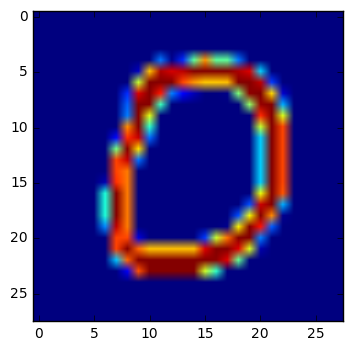

In [6]:
test_id = 10

## original
img = test[test_id][0].reshape([28,28])

plt.imshow(img)

#### 画像情報のみから復元

(<matplotlib.image.AxesImage at 0x1151e26d8>,
 array([[ 0.46953142,  0.02296825,  0.07605913,  0.15182728,  0.04360932,
          0.12155937,  0.05064033,  0.00845186,  0.15037778, -0.09594329]], dtype=float32))

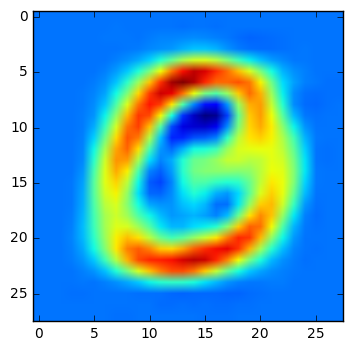

In [7]:
recX, recY = model.encX_dec(test[test_id][0][np.newaxis,: ])

plt.imshow(recX.reshape([28,28])), recY

#### ラベル情報のみから復元

(<matplotlib.image.AxesImage at 0x1165d6748>,
 array([[ 0.74500078,  0.06505256,  0.01926846,  0.0226884 ,  0.04845753,
          0.00156543,  0.02335991,  0.02846842,  0.00801516,  0.03739378]], dtype=float32))

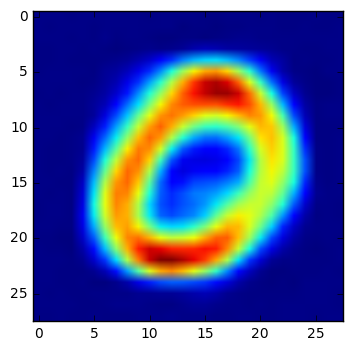

In [8]:
recX, recY = model.encY_dec(test[test_id][1][np.newaxis,: ])

plt.imshow(recX.reshape([28,28])), recY